<h1> Step 1: Load the data </h1>


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
import numpy as np
import uproot
import ROOT
import awkward as ak
import funcs
from hist import Hist, axis


tree_name= "Delphes"  #all of them are named delphes

#Signal
signal_folder = "data/signal/"
signal_filename =  "VBF_DM_My0_1000_MXD_10.root"
signal_file = uproot.open(signal_folder +signal_filename)


#Background
background_folder = "data/bkg/"
background_filename =  "run_01.root"
background_file = uproot.open(background_folder + background_filename)



#----
#will store data to be used in final "cut chart"
num_cuts = 5
SM_events = [1000,700,200]
NP_events = [500,400,300]
Significance = [1,2.4,5]
    #all this is temp for now




<h1> Step 2: Extract Data </h1>


In [34]:
#Signal Data
signal_tree = signal_file[tree_name]
signal_weights = signal_tree["Event/Event.Weight"].array(library="np")
normalized_signal_weights = signal_weights / np.mean(signal_weights)

signal_met_phi = signal_tree["MissingET.Phi"].array(library="np")


#Background Data
background_tree = background_file[tree_name]
background_weights = background_tree["Event/Event.Weight"].array(library="np")
normalized_background_weights = background_weights / np.mean(background_weights)

background_met_phi = background_tree["MissingET.Phi"].array(library="np")








<h1> Step 3: Plot Everything </h1>

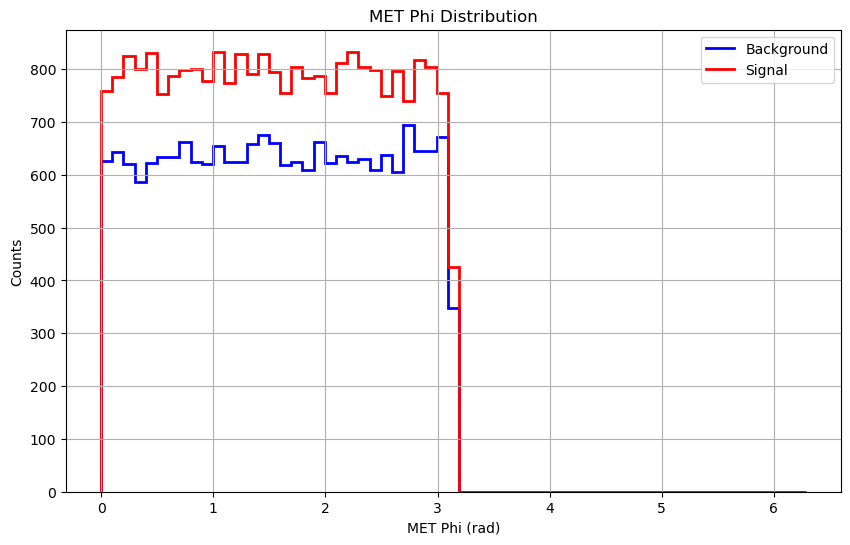

In [35]:
binning = {
    "PT": {"range": (20, 300), "bins": 14},  # (300 - 20) / 20 = 14 bins
    "Eta*Eta": {"range": (-25, 25), "bins": 500},  # (25 - (-25)) / 0.1 = 500 bins
    "Delta_Eta": {"range": (0, 10), "bins": 100},  # (10 - 0) / 0.1 = 100 bins
    "Transverse": {"range": (500, 2000), "bins": 75},  # (2000 - 500) / 20 = 75 bins
    "Eta": {"range": (-5, 5), "bins": 100},  # (5 - (-5)) / 0.1 = 100 bins
    "Phi": {"range": (0, 2 * np.pi), "bins": 63}  # (2 * pi - 0) / 0.1 = 63 bins
}

# Create histograms
met_phi_hist_background = Hist(
    axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
)
met_phi_hist_signal = Hist(
    axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
)

# Fill histograms with data
met_phi_hist_background.fill(MET_Phi=background_met_phi,weight = normalized_background_weights)
met_phi_hist_signal.fill(MET_Phi=signal_met_phi,weight = normalized_signal_weights)



# Plotting the histograms
plt.figure(figsize=(10, 6))

# Background histogram
plt.stairs(
    met_phi_hist_background.values(),
    met_phi_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

# Signal histogram
plt.stairs(
    met_phi_hist_signal.values(),
    met_phi_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=2
)

# Add labels and legend
plt.xlabel('MET Phi (rad)')
plt.ylabel('Counts')
plt.title('MET Phi Distribution')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<h1> Step 3: Iteratively Plot, then Cut <h1>

In [21]:
#Testing stuff

#this is how I might make a cut
trial = signalevents['Jet'][signalevents.Jet.PT > 30].compute()['PT']
trial


<b> $\eta$($j_0$) *  $\eta$($j_1$) </b>

<b> abs($\Delta$($j_0$,$j_1$)) </b>

<b>Pt($j_0$) </b>

<b>Pt($j_1$)</b>

<b> $M_{ET}$, <b>

<h1>Step 5: Compile full Cut Chart </h1>

In [ ]:

column_width = 12  

# Create the grid header
header_row = f"{'Cut #':^{column_width}} | {'SM Events':^{column_width}} | {'NP Events':^{column_width}} | {'Significance':^{column_width}}"
print(header_row)

# Print a separator line
print("-" * (len(header_row) + 1))

#Initial Conditions
init_data = f"{'    Init':{column_width}} | {SM_events[0]:^{column_width}} | {NP_events[0]:^{column_width}} | {Significance[0]:^{column_width}.2f}"  # 
print(init_data)

# Iterate through data and format each row
for i in range(1, num_cuts):  # Use range(1, num_cuts+1) for 1 to num_cuts (inclusive)
    row_data = f"{i:{column_width}} | {SM_events[i]:^{column_width}} | {NP_events[i]:^{column_width}} | {Significance[i]:^{column_width}.2f}" 
    print(row_data)


